# Registering multiple frames to first frame

In this notebook, we investigate methods for registering all frames in a video to the first frame. 

## Imports and magics

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

from otimage import imagerep, readers
from otimage.utils import plot_maxproj
from otimage.imagereg import ot_registration

## Load data

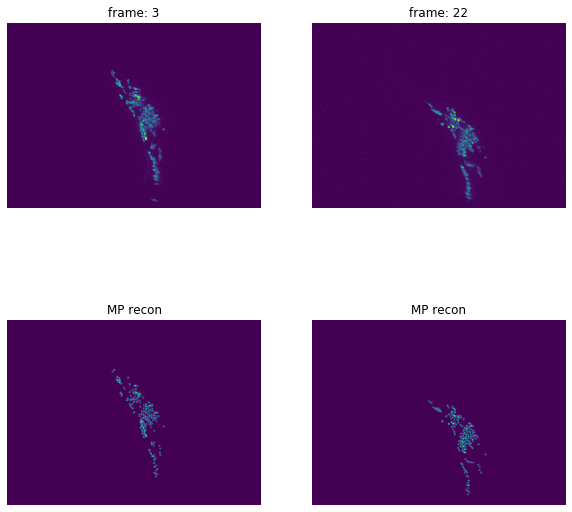

In [3]:
# Frames to load
t_start = 3
n_frames = 20
t_vals = range(t_start, t_start + n_frames)

# Load frames from dataset
img_path = '/home/mn2822/Desktop/WormOT/data/zimmer/raw/mCherry_v00065-00115.hdf5'
with readers.ZimmerReader(img_path) as reader:
    img = [reader.get_frame(t) for t in t_vals]
    img_shape = img[0].shape

# Load MP components
mp_path = '/home/mn2822/Desktop/WormOT/data/zimmer/mp_components/mp_0000_0050.mat'
mp_data = loadmat(mp_path)
cov = mp_data['cov']
pts = [mp_data['means'][t, :, :] for t in t_vals]
wts = [mp_data['weights'][t, :, 0] for t in t_vals]

# Reconstruct images from MPs
rec = [imagerep.reconstruct_image(pts[i], [cov], wts[i], img_shape) for i in range(n_frames)]

# Indices to plot
k1 = 0
k2 = -1
  
plt.figure(figsize=(10, 10))

plt.subplot(221)
plot_maxproj(img[k1])
plt.title(f'frame: {t_vals[k1]}')
plt.axis('off')

plt.subplot(222)
plot_maxproj(img[k2])
plt.title(f'frame: {t_vals[k2]}')
plt.axis('off');

plt.subplot(223)
plot_maxproj(rec[k1])
plt.title('MP recon')
plt.axis('off')

plt.subplot(224)
plot_maxproj(rec[k2])
plt.title('MP recon')
plt.axis('off');

## Approach 1: Register all frames to first frame directly

In [4]:
models_1 = [None] * (n_frames - 1)
debug_1 = [None] * (n_frames - 1)

for t in range(n_frames - 1):
    models_1[t], debug_1[t] = ot_registration(pts[0], pts[t + 1], wts[0], wts[t + 1], degree=3, n_iter=50)

## Reconstruct frame from mapping

(-0.5, 889.5, -0.5, 649.5)

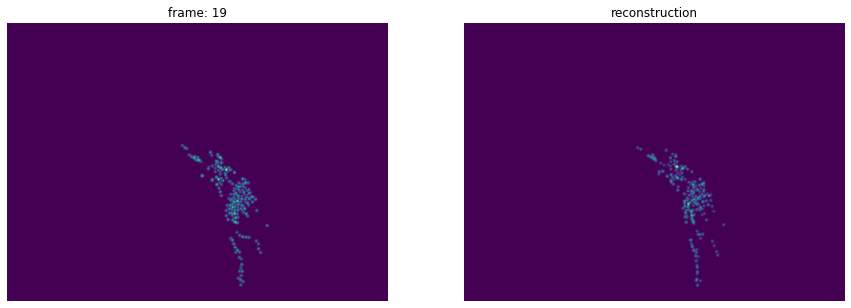

In [5]:
t = 19

t_rec_pts = models_1[t-1].predict(pts[0])
t_rec = imagerep.reconstruct_image_2(t_rec_pts, wts[0], cov, img_shape)

plt.figure(figsize=(15, 15))

plt.subplot(121)
plot_maxproj(rec[t])
plt.title(f'frame: {t}')
plt.axis('off')
        
plt.subplot(122)
plot_maxproj(t_rec)
plt.title('reconstruction')
plt.axis('off')

## Approach 2: Register all frames to first frame using pushforward

TODO: Re-visit this. Might be a bug -- it should be working at least as well as first approach.

In [6]:
models_2 = [None] * (n_frames - 1)
debug_2 = [None] * (n_frames - 1)

pf = [None] * n_frames
pf[0] = pts[0]

for t in range(n_frames - 1):
    
    models_2[t], debug_2[t] = ot_registration(pts[0], pts[t + 1], wts[0], wts[t + 1], 50, pf[t])
    pf[t + 1] = models_2[t].predict(pts[0])

NameError: name 'ot_reg_poly' is not defined

## Reconstruct frame from mapping

In [ ]:
t = 19

t_rec_pts = models_2[t-1].predict(pts[0])
t_rec = imagerep.reconstruct_image_2(t_rec_pts, wts[0], cov, img_shape)

plt.figure(figsize=(15, 15))

plt.subplot(121)
plot_maxproj(rec[t])
plt.title(f'frame: {t}')
plt.axis('off')
        
plt.subplot(122)
plot_maxproj(t_rec)
plt.title('reconstruction')
plt.axis('off')

plt.savefig('/home/mn2822/Desktop/frame_0_19_recon.png')